# Project Description

In this project, we are going to train Faster RCNN towards COCO dataset for object detection specifically for person tracking. The number of images in the train dataset is excessive, thus, for study purpose, we only use 500 images from the validation dataset. We use the COCO API which is available in python, otherwise we can install it.

In case if we want to re-run the whole notebook, we deleted the created files and folder first.

In [ ]:
!rm -rf data
!rm -rf coco_eval.py
!rm -rf coco_utils.py
!rm -rf engine.py
!rm -rf transforms.py
!rm -rf utils.py

# Prepare the Libraries

Firstly, we prepare the libraries that will support our project. We also download some of the python files from github to assist in some of our code.

In [ ]:
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=69ef9e91f192a53f451a616374e87eb2eccb782915ab11185f40c1290bbd58a8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# Libraries for general uses
import torch
import torchvision
import numpy as np
import wget
import utils
import cv2
import shutil
import time
from typing import Any, Callable, List, Optional, Tuple, Union

# Libraries for visualization
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# API for COCO dataset
from pycocotools.coco import COCO

# Libraries for image processing
from torchvision import transforms
from PIL import Image
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image

# Libraries for the machine learning model (faster RCNN)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate

# Libraries for accessing files and folder
import os.path
from pathlib import Path

# Data Preparation and Exploration

We download the annotation files which will help us in getting the required indexes of the images and their corresponding informations as well as in downloading the images files

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P data
!cd data && unzip annotations_trainval2017.zip

--2024-10-16 07:00:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.68.41, 3.5.20.124, 16.182.42.137, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.68.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘data/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  51.3MB/s    in 5.2s    

2024-10-16 07:00:28 (46.5 MB/s) - ‘data/annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


We apply the COCO API to acess the json file.

In [ ]:
# load annotations of train dataset
coco = COCO('./data/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


We explore some methods in the COCO API. Some demo of the API are available in their github. Here, we will see all of the categories and supercategories of the coco dataset.

In [ ]:
# This code is for checking all of the categories and supercategories of coco dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('The COCO categories are: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('The COCO supercategories are: \n{}'.format(' '.join(nms)))

The COCO categories are: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

The COCO supercategories are: 
accessory person vehicle kitchen food animal sports outdoor furniture indoor electronic appliance


Next, since we want to do person tracking, we explore how to filter the categories into person only, how to get the Ids of the images after filtering, and how to load the image's informations.

In [ ]:
# Filter the categories into the images which contain person
catIds = coco.getCatIds(catNms=['person'])
print(catIds)

# Get all of the image Ids with certain category
imgIds = coco.getImgIds(catIds=catIds)
print(imgIds)
print(len(imgIds))

# Among all of the imgIds, show the information of the first image
img = coco.loadImgs(imgIds[0])[0]
print(img)

[1]
[532481, 458755, 385029, 311303, 393226, 532493, 8211, 327701, 188439, 434204, 401446, 213033, 466986, 213035, 319534, 516143, 32817, 532530, 188465, 434230, 475191, 254016, 131138, 16451, 81988, 376900, 507975, 434247, 204871, 516173, 122962, 98392, 442456, 32861, 213086, 442463, 311392, 311394, 49259, 221291, 442480, 368752, 319607, 417911, 32887, 450686, 32901, 270474, 139, 180383, 82085, 385190, 524456, 90284, 32941, 188592, 229553, 278705, 213171, 336053, 549055, 114884, 508101, 65736, 303305, 344268, 532690, 360661, 16598, 73946, 114907, 426203, 278749, 516318, 229601, 295138, 467176, 319721, 352491, 33005, 458992, 475387, 393469, 57597, 426241, 540932, 106757, 65798, 180487, 213255, 147725, 418062, 147729, 377113, 229659, 147740, 426268, 434459, 205105, 565563, 278848, 368961, 352582, 57672, 74058, 123213, 33104, 336209, 180560, 483667, 8532, 270677, 262487, 491867, 475484, 393569, 549220, 336232, 74092, 467315, 131444, 434548, 532855, 442746, 541055, 426376, 336265, 303499,

We try to visualize the data by using the image link from the image's dictionary of information.

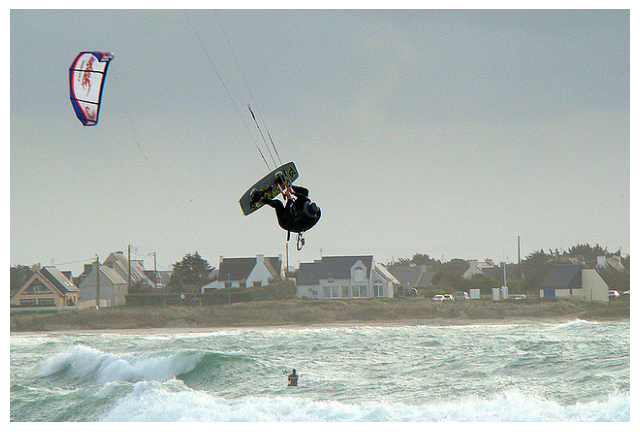

In [ ]:
# Visualize the image by selecting the coco_url of the image data
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

The coco API can also load the image's annotations which then can be visualized.

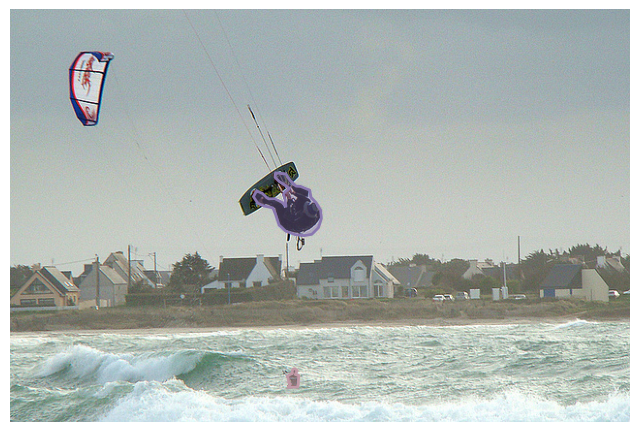

In [ ]:
# Sample annotation of the image
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

We want to know what the annotation file consist of by using the API.

In [ ]:
# Get the annotation Ids for certain image Id and category (the img file has been called in the previous cell)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
print(annIds)

# Load all of the annotation information
anns = coco.loadAnns(annIds)
print(anns)

# Check the len of annotation which means the number of person in this case
print(f'The number of person in this image is {len(anns)}')

[508910, 2021158]
[{'segmentation': [[253.85, 187.23, 250.82, 193.01, 255.22, 199.6, 260.99, 202.35, 270.89, 204.55, 273.64, 211.15, 277.21, 222.15, 284.09, 228.47, 293.71, 232.04, 303.06, 233.14, 311.03, 231.77, 317.9, 224.9, 320.93, 215.55, 320.1, 206.48, 315.43, 199.05, 310.2, 193.56, 308.83, 186.13, 299.48, 182.28, 294.81, 182.01, 288.49, 175.96, 284.09, 169.36, 273.64, 168.26, 273.09, 172.94, 277.49, 177.34, 283.81, 181.46, 287.94, 184.48, 283.26, 188.06, 281.61, 190.53, 283.54, 196.58, 284.36, 202.9, 279.96, 198.5, 272.54, 194.93, 266.77, 195.21, 265.12, 194.38, 259.89, 189.43, 254.12, 186.96]], 'area': 2188.0864999999994, 'iscrowd': 0, 'image_id': 532481, 'bbox': [250.82, 168.26, 70.11, 64.88], 'category_id': 1, 'id': 508910}, {'segmentation': [[295.86, 372.43, 293.99, 376.41, 293.99, 376.41, 297.62, 377.35, 296.8, 389.18, 296.8, 389.3, 286.49, 389.77, 289.07, 386.13, 287.19, 385.08, 286.73, 380.28, 285.55, 378.87, 287.31, 377.23, 289.07, 376.06, 291.06, 375.48, 290.82, 372.55, 

# Data Preprocessing

Now, we are going to download all of the images which contain person by implementing the API methods above. We firstly create the directory to store the images.

In [ ]:
directory = '/content/data/images'
os.makedirs(directory)

As we have called the imgIds, we only need to access the images' link and download it. We choose the first 500 images of the validation dataset.

In [ ]:
# Loading the information dictionary of all 500 images
imgIds = sorted(imgIds)
imgIds = imgIds[:500]
data = coco.loadImgs(imgIds)

# The download process of the images
for info in data:
  url = info['coco_url']
  file_name = info['file_name']
  file_path = os.path.join(directory, file_name)
  wget.download(url, file_path)

print('All files have been downloaded')

All files have been downloaded


We will prepare the dataset by coding the CocoDataset class which will return the tuple of the image and its information consisting of its binary masks and boxes. We create the binary mask within the class first which then we save it into a new folder.

In [ ]:
!mkdir ./data/Train
!mkdir ./data/Train/images
!mkdir ./data/Train/masks

In [ ]:
class CocoDataset():
    def __init__(self, catIds, imgIds, coco, root, transforms = None):
        self.catIds = catIds
        self.imgIds = sorted(imgIds)
        self.coco = coco
        self.root = root #'/content/data/images'
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))

    def CreateMask(self, imageObj, coco, catIds, input_image_size):
        annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        train_mask = np.zeros((input_image_size[1], input_image_size[0]))
        for a in range(len(anns)):
            new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)

            # The resize above will result in extraneous values so we need to use a threshold
            new_mask[new_mask >= 0.5] = 1
            new_mask[new_mask < 0.5] = 0

            train_mask = np.maximum(new_mask, train_mask)

        # Add extra dimension for parity with train_img size [X * X * 3]
        train_mask = train_mask.reshape(input_image_size[1], input_image_size[0], 1)
        return train_mask

    def __getitem__(self, idx):
        # Get the images
        img_path = os.path.join(self.root, self.imgs[idx])
        img = read_image(img_path)
        img = tv_tensors.Image(img)

        # Get the masks
        image_dict = self.coco.loadImgs(self.imgIds[idx])[0]
        image_mask = cv2.imread(os.path.join(self.root, image_dict['file_name']))
        msk = self.CreateMask(image_dict, self.coco, self.catIds, (image_mask.shape[1],image_mask.shape[0]))
        shutil.copyfile(os.path.join(self.root,image_dict['file_name']),
                            os.path.join('./data/Train/images/', image_dict['file_name']))
        masks_arr = np.zeros((1, image_mask.shape[0], image_mask.shape[1], 1), dtype = bool)
        masks_arr[0] = msk
        mask_img = masks_arr[0].astype('uint8')*255
        cv2.imwrite(os.path.join('./data/Train/masks/',image_dict['file_name']),mask_img)

        # Get the values for targets
        annIds = self.coco.getAnnIds(imgIds=image_dict['id'], catIds=self.catIds)
        anns = self.coco.loadAnns(annIds)
        image_id = image_dict['id']
        num_objs = len(anns)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        boxes = []
        area = []
        iscrowd = []

        # Convert the boxes into XYXY form
        for info in anns:
          area.append(info['area'])
          iscrowd.append(info['iscrowd'])

          x_min, y_min, width, height = info['bbox']
          x_max = x_min + width
          y_max = y_min + height
          boxes.append([x_min, y_min, x_max, y_max])

        # Change the list to tensor -> torch.tensor(my_list, dtype=torch.float)
        area = torch.tensor(area)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        # Save all the values into target
        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["masks"] = tv_tensors.Mask(mask_img)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Tranform the image and target if exist
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

We perform the transformation to increase the variety of the images which allows the model to learn from different perspectives of the same image and improve its ability to generalize to unseen data. We define the tranformation function as follows.

In [ ]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.ToImage())
        transforms.append(T.RandomPhotometricDistort(p=1))
        transforms.append(T.RandomHorizontalFlip(p=1))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

The following is the visualization of the transformation.

(-0.5, 639.5, 425.5, -0.5)

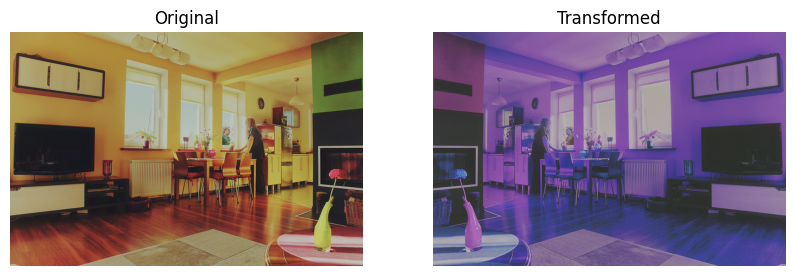

In [ ]:
image_path = '/content/data/images/000000000139.jpg'
img1 = read_image(image_path)
trans = get_transform(train=True)
img2 = trans(img1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot original image
axes[0].imshow(to_pil_image(img1))
axes[0].set_title('Original')
axes[0].axis('off')

    # Plot transformed image
axes[1].imshow(to_pil_image(img2))
axes[1].set_title('Transformed')
axes[1].axis('off')

We create the train, validation, and test dataset from the CocoDataset class.

In [ ]:
# The catIds, imgIds, coco, and get_transform have been defined previously
root = '/content/data/images'
train_dataset = CocoDataset(catIds = catIds, imgIds = imgIds, coco = coco, root = root, transforms = get_transform(train = True))
val_dataset = CocoDataset(catIds = catIds, imgIds = imgIds, coco = coco, root = root, transforms = get_transform(train = False))
test_dataset = CocoDataset(catIds = catIds, imgIds = imgIds, coco = coco, root = root, transforms = get_transform(train = False))

We divide the dataset into 400 images for train dataset, 50 images for validation dataset, and 50 images for test dataset.

In [ ]:
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:400])
val_dataset = torch.utils.data.Subset(test_dataset, indices[400:450])
test_dataset = torch.utils.data.Subset(test_dataset, indices[450:])

We create the data loader for the datasets as:
- In the training dataset, we use batch_size = 2 to group two samples into one batch to increase time productivity during training, while in test and validation data, we use batch_size = 1.
- In the training dataset, we use shuffle = True to shuffle the dataset at the beginning of each epoch, ensuring that the order in which samples are fed into the model changes every time. Shuffling the data is essential to prevent the model from learning the data order, which could introduce bias. In the test and validation dataset, we use shuffle = False.
- We set num_workers = 2 so that two parallel processes will load data in the background while the model trains so that it can speed up the data loading.
- collate_fn to collate the data into a batch, that is, how individual samples from the dataset are combined into a batch.


In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=utils.collate_fn
)

In [ ]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    collate_fn=utils.collate_fn
)

# Model Training and Evaluation

We will use the pretrained faster RCNN model and change the last fully connected layer into 2 which represent the classes that we are going to predict, i.e person and not person.

In [ ]:
num_classes = 2
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 111MB/s] 


In [ ]:
# Move the model to GPU if exist
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Setting the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Setting a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Setting the number of epochs
num_epochs = 50

losses = []
t0 = time.time()

# Training process
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    losses.append(loss)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    eval = evaluate(model, val_dataloader, device=device)

# Check the training duration
t1 = time.time()
training_duration = t1 - t0

print(f"The model has been trained and the training duration was {training_duration} seconds.")

/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/200]  eta: 0:12:21  lr: 0.000030  loss: 0.8789 (0.8789)  loss_classifier: 0.6836 (0.6836)  loss_box_reg: 0.1090 (0.1090)  loss_objectness: 0.0802 (0.0802)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 3.7075  data: 0.3710  max mem: 2354
Epoch: [0]  [ 10/200]  eta: 0:02:41  lr: 0.000281  loss: 1.2215 (1.2998)  loss_classifier: 0.5297 (0.5194)  loss_box_reg: 0.1090 (0.1214)  loss_objectness: 0.5067 (0.5940)  loss_rpn_box_reg: 0.0487 (0.0650)  time: 0.8475  data: 0.0446  max mem: 3599
Epoch: [0]  [ 20/200]  eta: 0:02:08  lr: 0.000532  loss: 0.8799 (1.0981)  loss_classifier: 0.3052 (0.3597)  loss_box_reg: 0.1507 (0.1337)  loss_objectness: 0.3742 (0.5301)  loss_rpn_box_reg: 0.0636 (0.0747)  time: 0.5646  data: 0.0112  max mem: 3599
Epoch: [0]  [ 30/200]  eta: 0:01:57  lr: 0.000783  loss: 0.7507 (0.9526)  loss_classifier: 0.2074 (0.3180)  loss_box_reg: 0.1703 (0.1564)  loss_objectness: 0.1916 (0.4134)  loss_rpn_box_reg: 0.0454 (0.0647)  time: 0.6015  data: 0.0125  max mem: 4210


We have a small score for precision and recall, meaning the model needs to be enhanced. The table shows that the highest precision is at IoU = 0.5, indicating that the model mainly yields the box at 50% of the actual box. The recall is a bit higher than the precision for IoU = 0.50:0.95, which tells us that the model is better at avoiding predicting a person as a non-person than vice versa. If we look at the image size, the model is worse at predicting small objects compared to medium and large objects. Thus, this model still need more improvement such as adding more images, increasing the epoch number, and adjusting parameter. Subsequently, we attempt to visualize the losses value of the training process as follows.

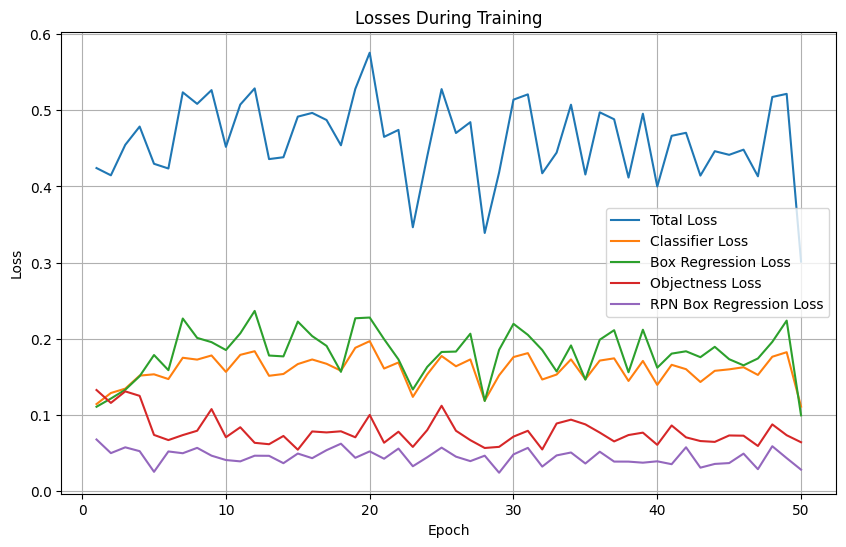

In [ ]:
# Assuming losses is an instance of MetricLogger
total_loss = []
loss_classifier = []
loss_box_reg = []
loss_objectness = []
loss_rpn_box_reg = []

# Access the metrics from MetricLogger
for loss in losses:  # If losses is a MetricLogger, iterate over it
    total_loss.append(loss.meters['loss'].avg)  # Average total loss
    loss_classifier.append(loss.meters['loss_classifier'].avg)  # Average classifier loss
    loss_box_reg.append(loss.meters['loss_box_reg'].avg)  # Average box regression loss
    loss_objectness.append(loss.meters['loss_objectness'].avg)  # Average objectness loss
    loss_rpn_box_reg.append(loss.meters['loss_rpn_box_reg'].avg)  # Average RPN box regression loss

# Generate epochs for x-axis
epochs = range(1, len(total_loss) + 1)

# Visualizing the losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, total_loss, label='Total Loss')
plt.plot(epochs, loss_classifier, label='Classifier Loss')
plt.plot(epochs, loss_box_reg, label='Box Regression Loss')
plt.plot(epochs, loss_objectness, label='Objectness Loss')
plt.plot(epochs, loss_rpn_box_reg, label='RPN Box Regression Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses During Training')
plt.legend()
plt.grid(True)
plt.show()


The loss scores consist of the following:
- Total loss: the total of all losses,
- Classifier loss: the loss that calculates the boxes over the wrong objects,
- Box regression loss: this loss measures how well the predicted bounding box matches the ground truth bounding box,
- Objectness loss: this loss is used to determine whether the proposed regions from the Region Proposal Network (RPN) actually contain an object (foreground) or not (background),
- RPN box regression loss: this loss measures how well the box proposals from RPN match the ground truth.

The graph shows losses approximately above 0.05 or 5%, meaning the model has a high loss in creating the boxes for person detection and needs to be enhanced.

# Model Testing and Visualization

Finally, we are going to test the model over the test dataset. We will calculate the MAP for some threshold values and visualize a sample of the test dataset. Firstly, we create the functions required for the MAP calculation.

In [ ]:
# A function to calculate the iou
def iou(box1, box2):
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

# A function to calculate the AP
def calculate_image_ap(gt_boxes, pred_boxes, iou_threshold):
    pred_boxes = sorted(pred_boxes, key=lambda x: x[1], reverse=True)
    gt_used = [False] * len(gt_boxes)
    tp, fp = [], []

    for pred_box in pred_boxes:
        matched_gt = -1
        for idx, gt_box in enumerate(gt_boxes):
            if gt_used[idx]:
                continue
            if iou(pred_box[0], gt_box[0]) > iou_threshold:
                matched_gt = idx
                break
        if matched_gt >= 0:
            tp.append(1)
            gt_used[matched_gt] = True
        else:
            tp.append(0)
        fp.append(1 - tp[-1])

    tp = np.cumsum(tp).tolist()
    fp = np.cumsum(fp).tolist()

    precisions = [tp[i] / (tp[i] + fp[i]) for i in range(len(tp))]
    recalls = [tp[i] / len(gt_boxes) for i in range(len(tp))]

    # The first and the last value is required for calculation if we see the precision-recall curve
    precisions = [0.] + precisions + [0.]
    recalls = [0.] + recalls + [1.]

    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    ap = 0.
    for i in range(1, len(precisions)):
        if recalls[i] != recalls[i - 1]:
            ap += (recalls[i] - recalls[i - 1]) * precisions[i]
    return ap

# Function to calculate the MAP
def calculate_map(gt_boxes_list, pred_boxes_list, iou_threshold):
    ap_list = [calculate_image_ap(gt_boxes, pred_boxes, iou_threshold) for gt_boxes, pred_boxes in zip(gt_boxes_list, pred_boxes_list)]
    return sum(ap_list) / len(ap_list)

Now, we are going to calculate the MAP of the resulting predictions.

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

# A list to collect all of the map in every threshold
map_five = []
map_six = []
map_seven = []
map_eight = []
map_nine = []

for images, targets in test_dataloader:
  images = list(img.to(device) for img in images)

  # Tracing the starting and finishing time for inference latency
  t0 = time.time()
  outputs = model(images)
  t1 = time.time()

  outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

  gt_boxes_list = []
  pred_boxes_list = []

  # Getting the ground truth boxes data
  for i in range(len(targets[0]['boxes'])):
    box = targets[0]['boxes'][i]
    label = targets[0]['labels'][i]
    data = [box.cpu().tolist(), label.cpu().item()]
    gt_boxes_list.append([data])

  # Getting the predicted boxes data
  for i in range(len(outputs[0]['boxes'])):
    box = outputs[0]['boxes'][i]
    score = outputs[0]['scores'][i]
    label = outputs[0]['labels'][i]
    data = [box.cpu().tolist(), score.cpu().item(), label.cpu().item()]
    pred_boxes_list.append([data])

  map = calculate_map(gt_boxes_list, pred_boxes_list, 0.5)
  map_five.append(map)

  map = calculate_map(gt_boxes_list, pred_boxes_list, 0.6)
  map_six.append(map)

  map = calculate_map(gt_boxes_list, pred_boxes_list, 0.7)
  map_seven.append(map)

  map = calculate_map(gt_boxes_list, pred_boxes_list, 0.8)
  map_eight.append(map)

  map = calculate_map(gt_boxes_list, pred_boxes_list, 0.9)
  map_nine.append(map)

avg_map_five = np.mean(map_five)
avg_map_six = np.mean(map_six)
avg_map_seven = np.mean(map_seven)
avg_map_eight = np.mean(map_eight)
avg_map_nine = np.mean(map_nine)
inference_latency = t1-t0

print(f'The inference latency of this model is {inference_latency} seconds')
print(f'The MAP for this model at threshold = 0.5 over test dataset is {avg_map_five}')
print(f'The MAP for this model at threshold = 0.6 over test dataset is {avg_map_six}')
print(f'The MAP for this model at threshold = 0.7 over test dataset is {avg_map_seven}')
print(f'The MAP for this model at threshold = 0.8 over test dataset is {avg_map_eight}')
print(f'The MAP for this model at threshold = 0.9 over test dataset is {avg_map_nine}')

The inference latency of this model is 0.11632776260375977 seconds
The MAP for this model at threshold = 0.5 over test dataset is 0.4632222222222222
The MAP for this model at threshold = 0.6 over test dataset is 0.37455555555555553
The MAP for this model at threshold = 0.7 over test dataset is 0.16747619047619047
The MAP for this model at threshold = 0.8 over test dataset is 0.09095238095238095
The MAP for this model at threshold = 0.9 over test dataset is 0.039523809523809524


Based on the results above, we can interpret as the following.
- Likewise, over the test dataset, the highest MAP score is when the threshold is 0.5, meaning that the model is better at predicting the bounding box at IoU greater or equal to 50%.
- However, the higher the IoU threshold, the worse the MAP score will be, and thus, the prediction will get worse.
- This indicates that the model can predict the object's position but cannot create a bounding box that covers the whole object at a high percentage.
- The inference latency is small, showing that the model runs quite fast.

In this section, we will visualize the resulting model over the last image. We plot the boxes only if they satisfy the threshold which we set as we want.

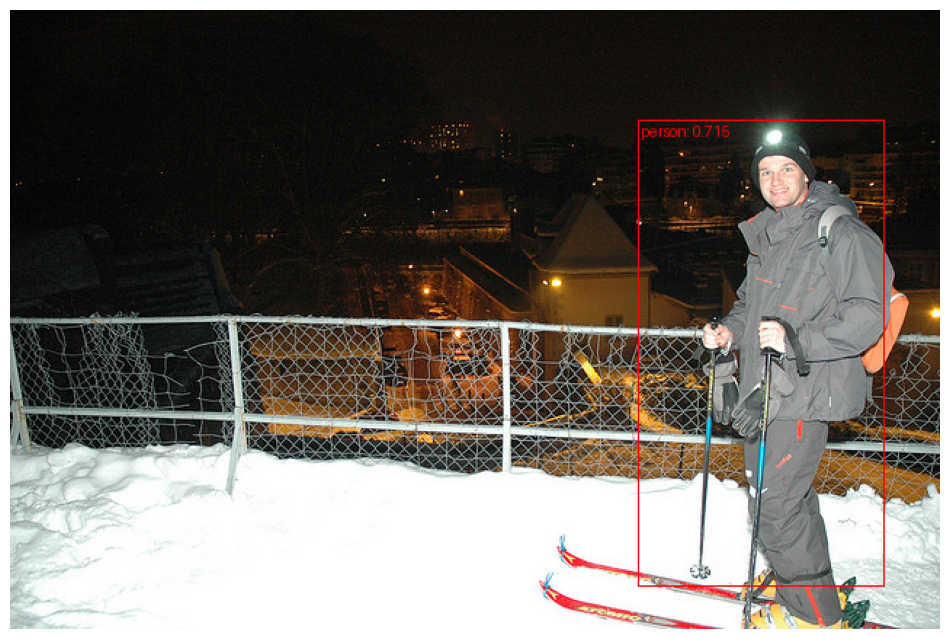

In [ ]:
# Define a score threshold to filter low-confidence predictions (the value is adjustable as needed)
score_threshold = 0.7

# Get the last image from the dataset
sample = test_dataset[-1]
image, target = sample

eval_transform = get_transform(train=False)
x = eval_transform(image)

# Convert RGBA to RGB and move to device
x = x[:3, ...].to(device)

# Set model to evaluation mode and do the predictions
model.eval()
with torch.no_grad():
    predictions = model([x, ])
    pred = predictions[0]

# Normalize and prepare the image for visualization
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Filter predictions to the boxes with score > threshold
valid_idx = pred["scores"] > score_threshold

# Apply the filtering to boxes, labels, and scores
pred_boxes = pred["boxes"][valid_idx].long()
pred_scores = pred["scores"][valid_idx]

# Prepare labels with scores for display
pred_labels_with_scores = [f"person: {score:.3f}" for score in pred_scores]

# Visualize the image with bounding boxes
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels_with_scores, colors="red")

# Display the image
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis("off")
plt.show()